In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_roi_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 304)
(463113, 1)
validation
(87055, 304)
(87055, 1)
test
(43409, 304)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1001473 (3.82 MB)


Trainable params: 1001473 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:00 - loss: 0.1377 - STD: 1.0560e-04 - MAE: 0.3552

 4/47 [=>............................] - ETA: 9s - loss: 0.0560 - STD: 1.4310e-04 - MAE: 0.1726  

 8/47 [====>.........................] - ETA: 4s - loss: 0.0403 - STD: 9.6055e-05 - MAE: 0.1502

12/47 [======>.......................] - ETA: 2s - loss: 0.0366 - STD: 7.0159e-05 - MAE: 0.1455

16/47 [=========>....................] - ETA: 1s - loss: 0.0332 - STD: 5.5400e-05 - MAE: 0.1380

20/47 [===========>..................] - ETA: 1s - loss: 0.0294 - STD: 4.6387e-05 - MAE: 0.1281

24/47 [==============>...............] - ETA: 0s - loss: 0.0266 - STD: 4.0362e-05 - MAE: 0.1222

28/47 [================>.............] - ETA: 0s - loss: 0.0249 - STD: 3.5793e-05 - MAE: 0.1196

32/47 [===================>..........] - ETA: 0s - loss: 0.0233 - STD: 3.2375e-05 - MAE: 0.1161

36/47 [=====================>........] - ETA: 0s - loss: 0.0221 - STD: 2.9808e-05 - MAE: 0.1125

40/47 [========================>.....] - ETA: 0s - loss: 0.0212 - STD: 2.7765e-05 - MAE: 0.1095

44/47 [===========================>..] - ETA: 0s - loss: 0.0204 - STD: 2.6117e-05 - MAE: 0.1072

47/47 [==============================] - 3s 43ms/step - loss: 0.0198 - STD: 2.5093e-05 - MAE: 0.1057 - val_loss: 0.0139 - val_STD: 8.3377e-06 - val_MAE: 0.0933


Epoch 2/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0121 - STD: 1.0280e-05 - MAE: 0.0871

 5/47 [==>...........................] - ETA: 0s - loss: 0.0123 - STD: 1.0551e-05 - MAE: 0.0886

10/47 [=====>........................] - ETA: 0s - loss: 0.0123 - STD: 1.0873e-05 - MAE: 0.0880

14/47 [=======>......................] - ETA: 0s - loss: 0.0121 - STD: 1.1091e-05 - MAE: 0.0868

18/47 [==========>...................] - ETA: 0s - loss: 0.0121 - STD: 1.1331e-05 - MAE: 0.0861

22/47 [=============>................] - ETA: 0s - loss: 0.0121 - STD: 1.1626e-05 - MAE: 0.0857

26/47 [===============>..............] - ETA: 0s - loss: 0.0121 - STD: 1.1958e-05 - MAE: 0.0857

30/47 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 1.2306e-05 - MAE: 0.0858

34/47 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 1.2662e-05 - MAE: 0.0857

38/47 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 1.3027e-05 - MAE: 0.0856

42/47 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 1.3400e-05 - MAE: 0.0856

46/47 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 1.3803e-05 - MAE: 0.0855

47/47 [==============================] - 1s 16ms/step - loss: 0.0121 - STD: 1.3904e-05 - MAE: 0.0855 - val_loss: 0.0140 - val_STD: 1.6834e-05 - val_MAE: 0.0925


Epoch 3/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0118 - STD: 1.8881e-05 - MAE: 0.0847

 6/47 [==>...........................] - ETA: 0s - loss: 0.0119 - STD: 1.9669e-05 - MAE: 0.0850

10/47 [=====>........................] - ETA: 0s - loss: 0.0120 - STD: 2.0142e-05 - MAE: 0.0851

14/47 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 2.0666e-05 - MAE: 0.0851

18/47 [==========>...................] - ETA: 0s - loss: 0.0120 - STD: 2.1231e-05 - MAE: 0.0851

22/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 2.1826e-05 - MAE: 0.0851

26/47 [===============>..............] - ETA: 0s - loss: 0.0121 - STD: 2.2475e-05 - MAE: 0.0852

30/47 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 2.3107e-05 - MAE: 0.0852

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 2.3755e-05 - MAE: 0.0852

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 2.4427e-05 - MAE: 0.0852

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 2.5114e-05 - MAE: 0.0851

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 2.5839e-05 - MAE: 0.0851

47/47 [==============================] - 1s 16ms/step - loss: 0.0120 - STD: 2.6029e-05 - MAE: 0.0851 - val_loss: 0.0140 - val_STD: 3.1497e-05 - val_MAE: 0.0924


Epoch 4/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0121 - STD: 3.5356e-05 - MAE: 0.0854

 5/47 [==>...........................] - ETA: 0s - loss: 0.0120 - STD: 3.6211e-05 - MAE: 0.0851

 9/47 [====>.........................] - ETA: 0s - loss: 0.0121 - STD: 3.7118e-05 - MAE: 0.0853

14/47 [=======>......................] - ETA: 0s - loss: 0.0121 - STD: 3.8354e-05 - MAE: 0.0854

18/47 [==========>...................] - ETA: 0s - loss: 0.0121 - STD: 3.9392e-05 - MAE: 0.0853

22/47 [=============>................] - ETA: 0s - loss: 0.0121 - STD: 4.0503e-05 - MAE: 0.0853

26/47 [===============>..............] - ETA: 0s - loss: 0.0121 - STD: 4.1661e-05 - MAE: 0.0854

30/47 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 4.2880e-05 - MAE: 0.0854

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 4.4116e-05 - MAE: 0.0853

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 4.5374e-05 - MAE: 0.0852

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 4.6788e-05 - MAE: 0.0852

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 4.8281e-05 - MAE: 0.0852

47/47 [==============================] - 1s 16ms/step - loss: 0.0120 - STD: 4.8653e-05 - MAE: 0.0852 - val_loss: 0.0140 - val_STD: 5.9647e-05 - val_MAE: 0.0924


Epoch 5/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0119 - STD: 6.6518e-05 - MAE: 0.0849

 5/47 [==>...........................] - ETA: 0s - loss: 0.0119 - STD: 6.8703e-05 - MAE: 0.0846

 9/47 [====>.........................] - ETA: 0s - loss: 0.0120 - STD: 7.0668e-05 - MAE: 0.0848

13/47 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 7.3229e-05 - MAE: 0.0850

17/47 [=========>....................] - ETA: 0s - loss: 0.0120 - STD: 7.5635e-05 - MAE: 0.0851

21/47 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 7.8173e-05 - MAE: 0.0851

25/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 8.0801e-05 - MAE: 0.0850

29/47 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 8.3696e-05 - MAE: 0.0851

33/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 8.6873e-05 - MAE: 0.0851

37/47 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 9.0290e-05 - MAE: 0.0851

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 9.4824e-05 - MAE: 0.0851

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 9.8770e-05 - MAE: 0.0851

47/47 [==============================] - 1s 16ms/step - loss: 0.0120 - STD: 9.9819e-05 - MAE: 0.0851 - val_loss: 0.0140 - val_STD: 1.3190e-04 - val_MAE: 0.0923


Epoch 6/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0118 - STD: 1.4845e-04 - MAE: 0.0838

 5/47 [==>...........................] - ETA: 0s - loss: 0.0121 - STD: 1.5469e-04 - MAE: 0.0850

 9/47 [====>.........................] - ETA: 0s - loss: 0.0120 - STD: 1.6163e-04 - MAE: 0.0849

13/47 [=======>......................] - ETA: 0s - loss: 0.0120 - STD: 1.6924e-04 - MAE: 0.0849

17/47 [=========>....................] - ETA: 0s - loss: 0.0120 - STD: 1.7681e-04 - MAE: 0.0851

21/47 [============>.................] - ETA: 0s - loss: 0.0120 - STD: 1.8505e-04 - MAE: 0.0850

25/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 1.9412e-04 - MAE: 0.0851

29/47 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 2.0376e-04 - MAE: 0.0851

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 2.1718e-04 - MAE: 0.0850

38/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 2.2898e-04 - MAE: 0.0850

42/47 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 2.4212e-04 - MAE: 0.0850

46/47 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 2.5686e-04 - MAE: 0.0850

47/47 [==============================] - 1s 16ms/step - loss: 0.0120 - STD: 2.6087e-04 - MAE: 0.0850 - val_loss: 0.0140 - val_STD: 3.9503e-04 - val_MAE: 0.0921


Epoch 7/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0119 - STD: 4.5078e-04 - MAE: 0.0848

 5/47 [==>...........................] - ETA: 0s - loss: 0.0120 - STD: 4.7600e-04 - MAE: 0.0850

 9/47 [====>.........................] - ETA: 0s - loss: 0.0119 - STD: 5.0688e-04 - MAE: 0.0846

13/47 [=======>......................] - ETA: 0s - loss: 0.0119 - STD: 5.4202e-04 - MAE: 0.0848

17/47 [=========>....................] - ETA: 0s - loss: 0.0119 - STD: 5.8153e-04 - MAE: 0.0847

21/47 [============>.................] - ETA: 0s - loss: 0.0119 - STD: 6.2593e-04 - MAE: 0.0849

25/47 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 6.7632e-04 - MAE: 0.0848

29/47 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 7.3296e-04 - MAE: 0.0848

33/47 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 7.9938e-04 - MAE: 0.0848

38/47 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 8.9899e-04 - MAE: 0.0847

42/47 [=========================>....] - ETA: 0s - loss: 0.0119 - STD: 9.9309e-04 - MAE: 0.0847

46/47 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0848    

47/47 [==============================] - 1s 16ms/step - loss: 0.0119 - STD: 0.0011 - MAE: 0.0847 - val_loss: 0.0137 - val_STD: 0.0024 - val_MAE: 0.0912


Epoch 8/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0117 - STD: 0.0027 - MAE: 0.0840

 5/47 [==>...........................] - ETA: 0s - loss: 0.0118 - STD: 0.0030 - MAE: 0.0843

 9/47 [====>.........................] - ETA: 0s - loss: 0.0118 - STD: 0.0034 - MAE: 0.0843

13/47 [=======>......................] - ETA: 0s - loss: 0.0116 - STD: 0.0039 - MAE: 0.0840

17/47 [=========>....................] - ETA: 0s - loss: 0.0116 - STD: 0.0044 - MAE: 0.0837

21/47 [============>.................] - ETA: 0s - loss: 0.0115 - STD: 0.0051 - MAE: 0.0835

26/47 [===============>..............] - ETA: 0s - loss: 0.0114 - STD: 0.0062 - MAE: 0.0832

30/47 [==================>...........] - ETA: 0s - loss: 0.0113 - STD: 0.0073 - MAE: 0.0827

34/47 [====================>.........] - ETA: 0s - loss: 0.0111 - STD: 0.0086 - MAE: 0.0822

38/47 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.0102 - MAE: 0.0818

42/47 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 0.0121 - MAE: 0.0811

46/47 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 0.0142 - MAE: 0.0805

47/47 [==============================] - 1s 17ms/step - loss: 0.0106 - STD: 0.0148 - MAE: 0.0804 - val_loss: 0.0113 - val_STD: 0.0329 - val_MAE: 0.0816


Epoch 9/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0087 - STD: 0.0419 - MAE: 0.0728

 5/47 [==>...........................] - ETA: 0s - loss: 0.0086 - STD: 0.0454 - MAE: 0.0721

 9/47 [====>.........................] - ETA: 0s - loss: 0.0084 - STD: 0.0484 - MAE: 0.0713

13/47 [=======>......................] - ETA: 0s - loss: 0.0084 - STD: 0.0509 - MAE: 0.0709

17/47 [=========>....................] - ETA: 0s - loss: 0.0083 - STD: 0.0528 - MAE: 0.0705

21/47 [============>.................] - ETA: 0s - loss: 0.0083 - STD: 0.0541 - MAE: 0.0703

25/47 [==============>...............] - ETA: 0s - loss: 0.0082 - STD: 0.0550 - MAE: 0.0699

29/47 [=================>............] - ETA: 0s - loss: 0.0082 - STD: 0.0557 - MAE: 0.0697

33/47 [====================>.........] - ETA: 0s - loss: 0.0081 - STD: 0.0561 - MAE: 0.0695

37/47 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0564 - MAE: 0.0693

41/47 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0568 - MAE: 0.0691

46/47 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0573 - MAE: 0.0689

47/47 [==============================] - 1s 16ms/step - loss: 0.0081 - STD: 0.0573 - MAE: 0.0688 - val_loss: 0.0101 - val_STD: 0.0522 - val_MAE: 0.0759


Epoch 10/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0078 - STD: 0.0631 - MAE: 0.0680

 5/47 [==>...........................] - ETA: 0s - loss: 0.0077 - STD: 0.0618 - MAE: 0.0670

 9/47 [====>.........................] - ETA: 0s - loss: 0.0077 - STD: 0.0618 - MAE: 0.0667

13/47 [=======>......................] - ETA: 0s - loss: 0.0077 - STD: 0.0619 - MAE: 0.0668

17/47 [=========>....................] - ETA: 0s - loss: 0.0077 - STD: 0.0620 - MAE: 0.0667

21/47 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.0622 - MAE: 0.0666

25/47 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0623 - MAE: 0.0667

29/47 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0625 - MAE: 0.0666

33/47 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.0627 - MAE: 0.0665

37/47 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0628 - MAE: 0.0664

41/47 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0629 - MAE: 0.0663

45/47 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0630 - MAE: 0.0662

47/47 [==============================] - 1s 16ms/step - loss: 0.0076 - STD: 0.0631 - MAE: 0.0662 - val_loss: 0.0097 - val_STD: 0.0539 - val_MAE: 0.0733


Epoch 11/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0075 - STD: 0.0639 - MAE: 0.0658

 5/47 [==>...........................] - ETA: 0s - loss: 0.0075 - STD: 0.0632 - MAE: 0.0653

 9/47 [====>.........................] - ETA: 0s - loss: 0.0074 - STD: 0.0640 - MAE: 0.0651

13/47 [=======>......................] - ETA: 0s - loss: 0.0074 - STD: 0.0643 - MAE: 0.0651

17/47 [=========>....................] - ETA: 0s - loss: 0.0075 - STD: 0.0643 - MAE: 0.0652

22/47 [=============>................] - ETA: 0s - loss: 0.0075 - STD: 0.0645 - MAE: 0.0652

26/47 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.0648 - MAE: 0.0651

30/47 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0650 - MAE: 0.0650

34/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0651 - MAE: 0.0650

38/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0653 - MAE: 0.0648

42/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0654 - MAE: 0.0648

46/47 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0655 - MAE: 0.0647

47/47 [==============================] - 1s 16ms/step - loss: 0.0074 - STD: 0.0656 - MAE: 0.0647 - val_loss: 0.0100 - val_STD: 0.0557 - val_MAE: 0.0730


Epoch 12/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0073 - STD: 0.0672 - MAE: 0.0636

 5/47 [==>...........................] - ETA: 0s - loss: 0.0073 - STD: 0.0671 - MAE: 0.0639

10/47 [=====>........................] - ETA: 0s - loss: 0.0072 - STD: 0.0670 - MAE: 0.0638

14/47 [=======>......................] - ETA: 0s - loss: 0.0072 - STD: 0.0670 - MAE: 0.0638

18/47 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0669 - MAE: 0.0636

22/47 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0672 - MAE: 0.0635

26/47 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0672 - MAE: 0.0635

30/47 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0674 - MAE: 0.0634

34/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0676 - MAE: 0.0634

38/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0677 - MAE: 0.0634

42/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0678 - MAE: 0.0634

46/47 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0679 - MAE: 0.0633

47/47 [==============================] - 1s 16ms/step - loss: 0.0071 - STD: 0.0679 - MAE: 0.0633 - val_loss: 0.0103 - val_STD: 0.0560 - val_MAE: 0.0736


Epoch 13/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0657 - MAE: 0.0617

 5/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0680 - MAE: 0.0627

 9/47 [====>.........................] - ETA: 0s - loss: 0.0070 - STD: 0.0685 - MAE: 0.0627

13/47 [=======>......................] - ETA: 0s - loss: 0.0070 - STD: 0.0690 - MAE: 0.0627

17/47 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0692 - MAE: 0.0624

21/47 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.0692 - MAE: 0.0623

25/47 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0694 - MAE: 0.0623

30/47 [==================>...........] - ETA: 0s - loss: 0.0069 - STD: 0.0694 - MAE: 0.0623

34/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0693 - MAE: 0.0623

38/47 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0695 - MAE: 0.0624

42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0695 - MAE: 0.0624

46/47 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0696 - MAE: 0.0624

47/47 [==============================] - 1s 16ms/step - loss: 0.0069 - STD: 0.0696 - MAE: 0.0624 - val_loss: 0.0099 - val_STD: 0.0618 - val_MAE: 0.0724


Epoch 14/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0721 - MAE: 0.0620

 5/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0620

 9/47 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0710 - MAE: 0.0620

13/47 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0710 - MAE: 0.0619

18/47 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0619

22/47 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0711 - MAE: 0.0618

26/47 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0618

30/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0618

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0711 - MAE: 0.0618

38/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0711 - MAE: 0.0618

42/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0711 - MAE: 0.0617

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0617

47/47 [==============================] - 1s 16ms/step - loss: 0.0068 - STD: 0.0713 - MAE: 0.0617 - val_loss: 0.0097 - val_STD: 0.0618 - val_MAE: 0.0716


Epoch 15/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0720 - MAE: 0.0610

 5/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0716 - MAE: 0.0609

10/47 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0613

14/47 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0724 - MAE: 0.0612

18/47 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0720 - MAE: 0.0612

22/47 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0720 - MAE: 0.0613

26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0720 - MAE: 0.0613

30/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0614

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0614

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0719 - MAE: 0.0613

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0720 - MAE: 0.0613

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0720 - MAE: 0.0612

47/47 [==============================] - 1s 16ms/step - loss: 0.0067 - STD: 0.0720 - MAE: 0.0612 - val_loss: 0.0101 - val_STD: 0.0605 - val_MAE: 0.0724


Epoch 16/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0692 - MAE: 0.0605

 6/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0722 - MAE: 0.0608

10/47 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0725 - MAE: 0.0606

14/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0725 - MAE: 0.0606

18/47 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0726 - MAE: 0.0606

22/47 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0607

26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0606

30/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0605

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0605

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0605

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0605

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0605

47/47 [==============================] - 1s 16ms/step - loss: 0.0066 - STD: 0.0729 - MAE: 0.0605 - val_loss: 0.0094 - val_STD: 0.0652 - val_MAE: 0.0704


Epoch 17/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0754 - MAE: 0.0609

 5/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0608

 9/47 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0608

13/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0608

17/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0606

21/47 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0730 - MAE: 0.0604

26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0604

30/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0604

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0603

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0603

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0603

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0732 - MAE: 0.0603

47/47 [==============================] - 1s 16ms/step - loss: 0.0065 - STD: 0.0732 - MAE: 0.0603 - val_loss: 0.0093 - val_STD: 0.0656 - val_MAE: 0.0700


Epoch 18/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0759 - MAE: 0.0607

 5/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0743 - MAE: 0.0602

 9/47 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0742 - MAE: 0.0601

14/47 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0746 - MAE: 0.0602

18/47 [==========>...................] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0602

22/47 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0601

26/47 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0601

30/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0600

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0601

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0601

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0601

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0600

47/47 [==============================] - 1s 16ms/step - loss: 0.0065 - STD: 0.0736 - MAE: 0.0600 - val_loss: 0.0098 - val_STD: 0.0627 - val_MAE: 0.0714


Epoch 19/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0063 - STD: 0.0737 - MAE: 0.0592

 5/47 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0727 - MAE: 0.0590

 9/47 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0737 - MAE: 0.0590

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0592

17/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0736 - MAE: 0.0593

22/47 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0737 - MAE: 0.0595

26/47 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0595

30/47 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0595

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0739 - MAE: 0.0595

38/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0595

42/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0741 - MAE: 0.0595

46/47 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0595

47/47 [==============================] - 1s 16ms/step - loss: 0.0064 - STD: 0.0740 - MAE: 0.0596 - val_loss: 0.0099 - val_STD: 0.0628 - val_MAE: 0.0714


Epoch 20/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0598

 5/47 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0753 - MAE: 0.0591

 9/47 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0592

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0592

17/47 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0594

21/47 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0595

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0744 - MAE: 0.0595

30/47 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0595

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0595

38/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0740 - MAE: 0.0596

42/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0596

46/47 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0742 - MAE: 0.0596

47/47 [==============================] - 1s 16ms/step - loss: 0.0064 - STD: 0.0741 - MAE: 0.0596 - val_loss: 0.0099 - val_STD: 0.0631 - val_MAE: 0.0715


Epoch 21/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0730 - MAE: 0.0597

 6/47 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0743 - MAE: 0.0601

10/47 [=====>........................] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0600

14/47 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0598

18/47 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0735 - MAE: 0.0598

22/47 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0599

26/47 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0599

30/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0599

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0738 - MAE: 0.0598

38/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0738 - MAE: 0.0597

42/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0738 - MAE: 0.0597

46/47 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0739 - MAE: 0.0597

47/47 [==============================] - 1s 16ms/step - loss: 0.0064 - STD: 0.0739 - MAE: 0.0597 - val_loss: 0.0100 - val_STD: 0.0630 - val_MAE: 0.0716


Epoch 22/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0740 - MAE: 0.0579

 6/47 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0738 - MAE: 0.0588

10/47 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0740 - MAE: 0.0588

14/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590

18/47 [==========>...................] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

22/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590

26/47 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590

30/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0746 - MAE: 0.0590

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0590

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0590

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0590

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0590

47/47 [==============================] - 1s 16ms/step - loss: 0.0063 - STD: 0.0748 - MAE: 0.0590 - val_loss: 0.0099 - val_STD: 0.0640 - val_MAE: 0.0713


Epoch 23/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0756 - MAE: 0.0574

 5/47 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0744 - MAE: 0.0588

 9/47 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0745 - MAE: 0.0590

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0747 - MAE: 0.0591

17/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0749 - MAE: 0.0591

21/47 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0589

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0588

30/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0589

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0588

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0589

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0589

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0588

47/47 [==============================] - 1s 16ms/step - loss: 0.0063 - STD: 0.0751 - MAE: 0.0588 - val_loss: 0.0095 - val_STD: 0.0676 - val_MAE: 0.0702


Epoch 24/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0786 - MAE: 0.0597

 5/47 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0761 - MAE: 0.0590

 9/47 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0589

13/47 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0588

17/47 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0751 - MAE: 0.0589

21/47 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0589

26/47 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0753 - MAE: 0.0588

30/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0588

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0589

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0589

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0752 - MAE: 0.0589

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0751 - MAE: 0.0589

47/47 [==============================] - 1s 16ms/step - loss: 0.0063 - STD: 0.0750 - MAE: 0.0589 - val_loss: 0.0094 - val_STD: 0.0668 - val_MAE: 0.0702


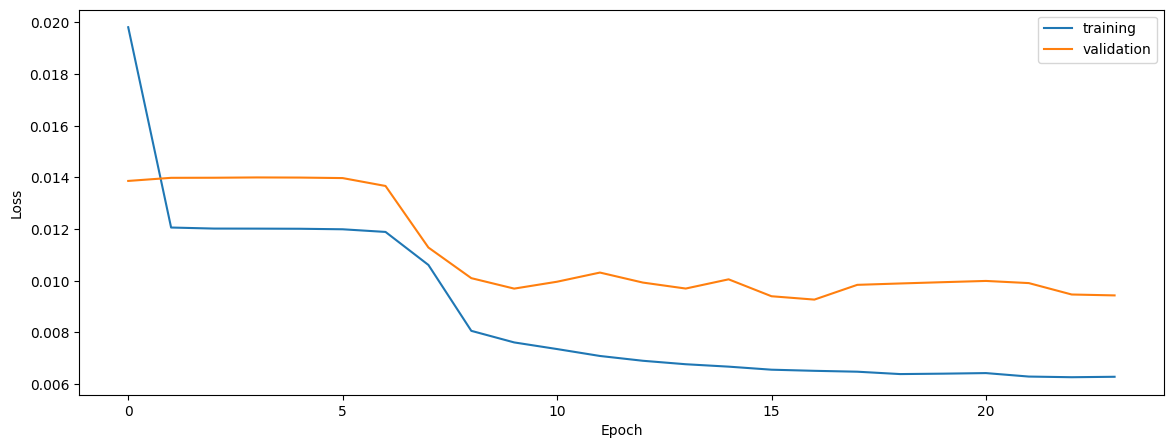

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6812104239198973
0.6092005793688373
0.6565734677262486


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6744212246880859
0.6330683505548058
0.6561900724934105


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6788841045434953
0.6383948863822604
0.6742552888449324


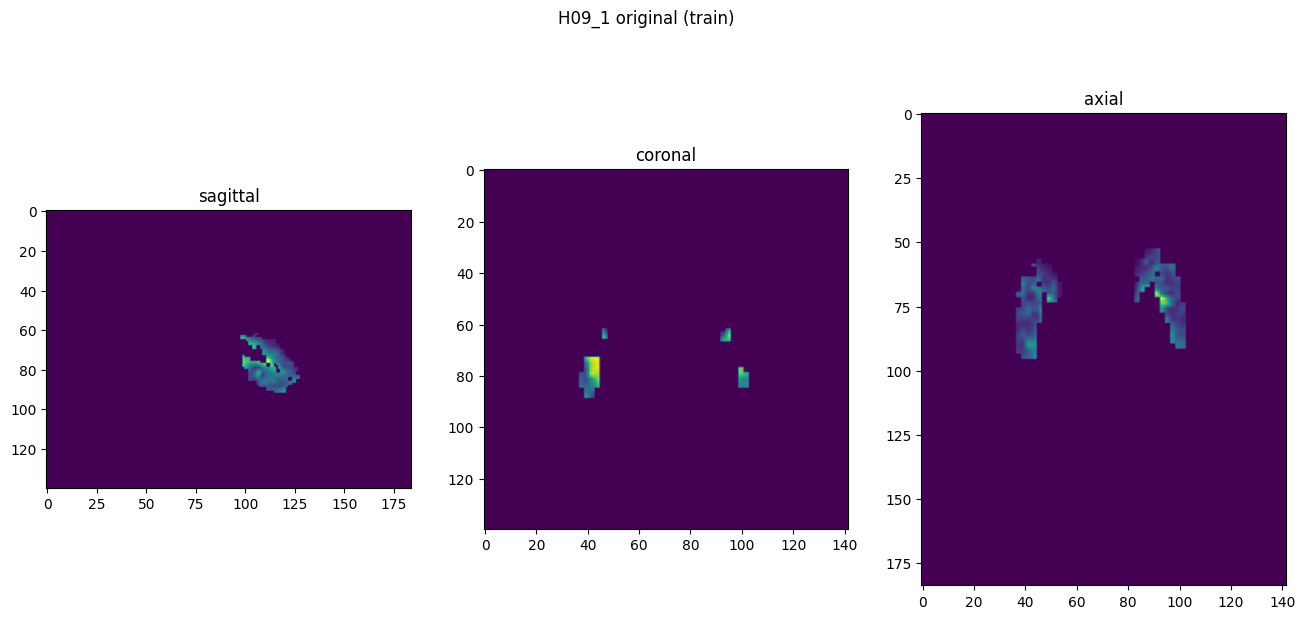

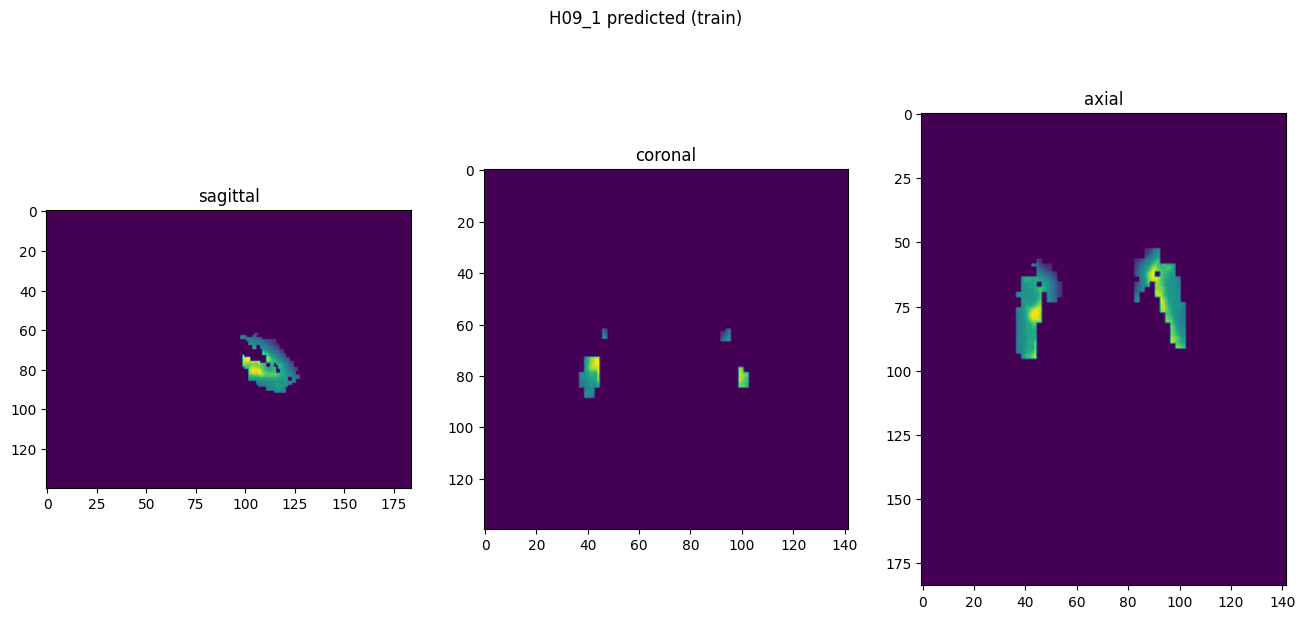

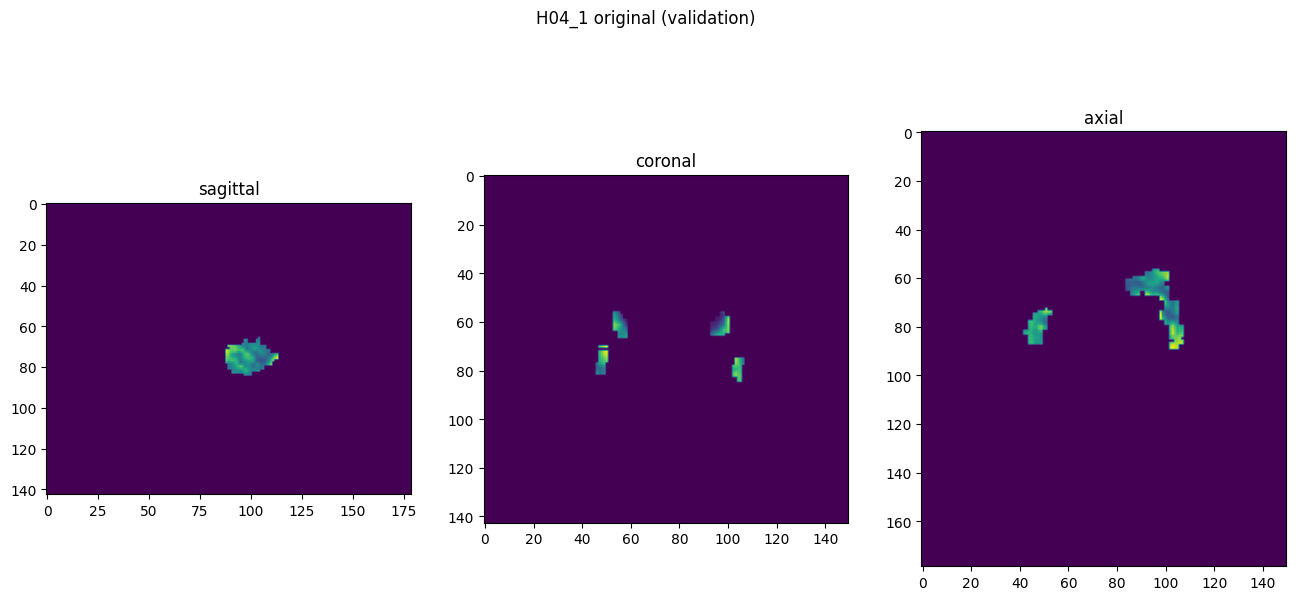

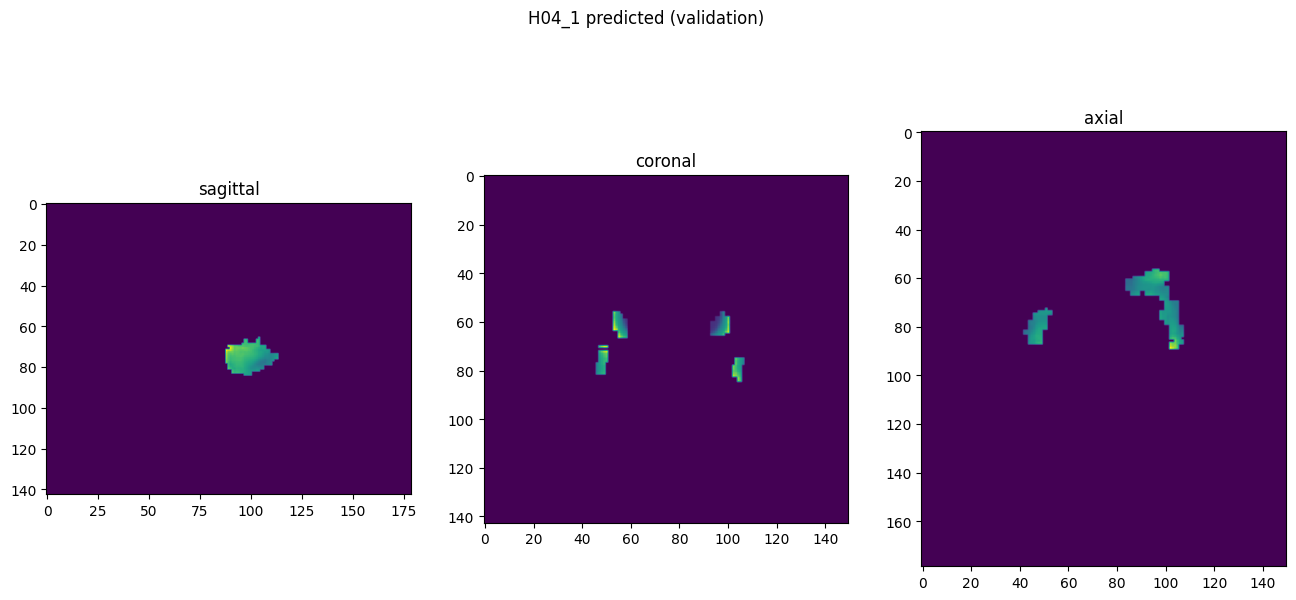

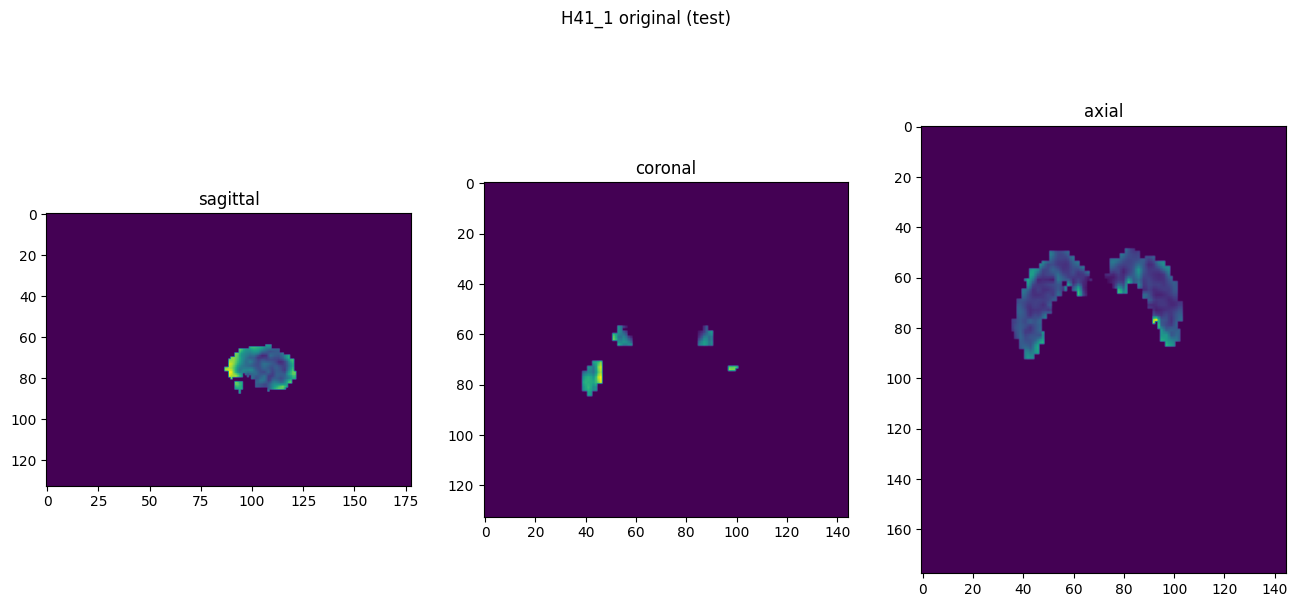

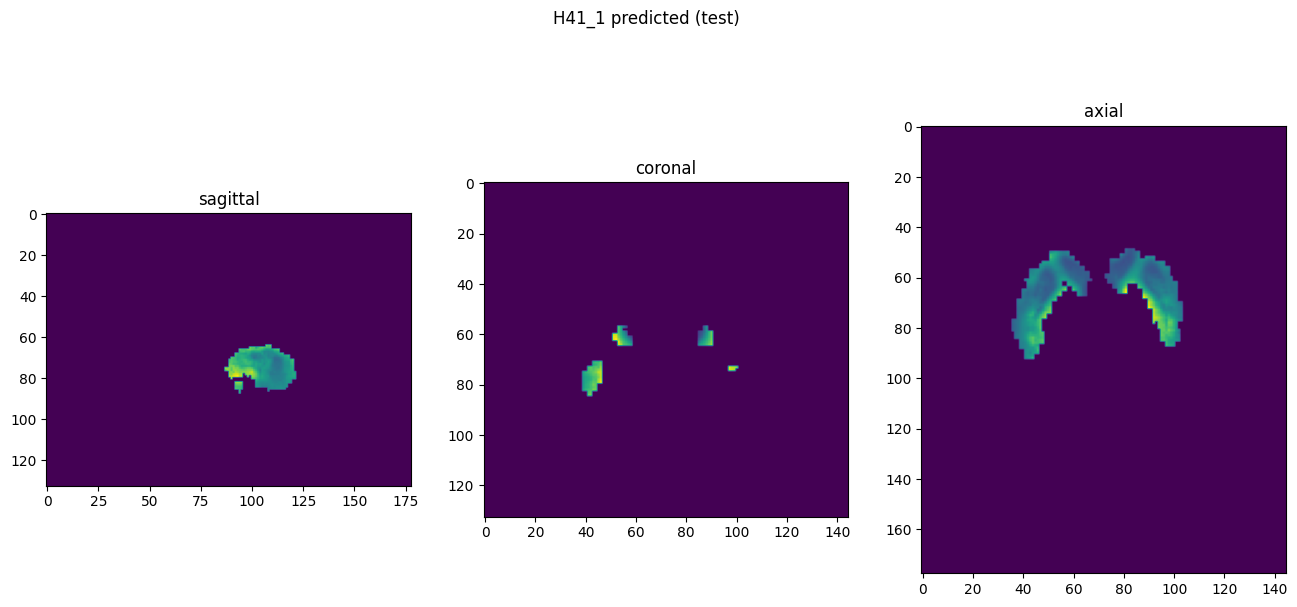

In [10]:
showResults(model, gen, threshold=None, background=False)